<a href="https://colab.research.google.com/github/Bhimsendabby/Machine--Learning-practice/blob/main/Image_Colorization_Using_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoder Image Colorization

This document provides a step-by-step guide to building an autoencoder using the images dataset. The autoencoder is a type of neural network that learns to compress (encode) the data and then reconstruct (decode) it back to the original form. But in this code we are using autoencoder for image colorization which is a application of autoencoder.

## Table of Contents

1. [Introduction](#introduction)
2. [Setup & Importing Modules](#setup)
3. [Loading Dataset & Data Preprocessing](#data-preprocessing)
4. [Building the Autoencoder](#building-the-autoencoder)
5. [Training the Autoencoder](#training-the-autoencoder)
6. [Evaluating the Autoencoder](#evaluating-the-autoencoder)
7. [Conclusion](#conclusion)

## Introduction

An autoencoder is a type of artificial neural network used to learn efficient codings of unlabeled data (unsupervised learning). The goal of an autoencoder is to learn a representation (encoding) for a set of data, typically for the purpose of dimensionality reduction.

## Setup

First, ensure you have the necessary libraries installed. You can install them using pip if you haven't already.

```bash
pip install torch numpy matplotlib

#Importing Modules

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Importing all the required libraries
import os
from torchvision.io import read_image
import torch
import torch.utils.data
from torch.utils.data import DataLoader,dataset, random_split
import torchvision
from torchvision import transforms,datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import time

from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler
from torch.utils.data import sampler
import matplotlib.colors as mcolors

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
print(device)

cuda


#Loading Dataset

In [4]:
!kaggle datasets download -d theblackmamba31/landscape-image-colorization

Dataset URL: https://www.kaggle.com/datasets/theblackmamba31/landscape-image-colorization
License(s): unknown
 97% 187M/192M [00:02<00:00, 103MB/s]
100% 192M/192M [00:02<00:00, 99.7MB/s]


In [5]:
!unzip landscape-image-colorization.zip

Streaming output truncated to the last 5000 lines.
  inflating: landscape Images/gray/2914.jpg  
  inflating: landscape Images/gray/2915.jpg  
  inflating: landscape Images/gray/2916.jpg  
  inflating: landscape Images/gray/2917.jpg  
  inflating: landscape Images/gray/2918.jpg  
  inflating: landscape Images/gray/2919.jpg  
  inflating: landscape Images/gray/292.jpg  
  inflating: landscape Images/gray/2920.jpg  
  inflating: landscape Images/gray/2921.jpg  
  inflating: landscape Images/gray/2922.jpg  
  inflating: landscape Images/gray/2923.jpg  
  inflating: landscape Images/gray/2924.jpg  
  inflating: landscape Images/gray/2925.jpg  
  inflating: landscape Images/gray/2926.jpg  
  inflating: landscape Images/gray/2927.jpg  
  inflating: landscape Images/gray/2928.jpg  
  inflating: landscape Images/gray/2929.jpg  
  inflating: landscape Images/gray/293.jpg  
  inflating: landscape Images/gray/2930.jpg  
  inflating: landscape Images/gray/2931.jpg  
  inflating: landscape Images/g

# Hyperparameters

In [6]:
RANDOM_SEED = 49
LEARNING_RATE = 0.0005
BATCH_SIZE = 64
NUM_EPOCHS = 5
MANUAL_SEED = 42
SHUFFLE = True

model_path = '/content/drive/MyDrive/models/imagecolorization_autoencoder.pth'
model_path2 = '/content/drive/MyDrive/models/Conv_autoencoder_2.pth'

# Image Pre-processing

In [7]:
class ImageDataset(torch.utils.data.Dataset):
  def __init__(self,root_directory,transform=None):
    self.directory = root_directory
    self.transform = transform
    self.color_images_labels = os.listdir(os.path.join(root_directory,'color'))
    self.gray_images_labels = os.listdir(os.path.join(root_directory,'gray'))


    self.images = []
    self.colors = []

  def __len__(self):
      return len(self.color_images_labels)

  def __getitem__(self, idx):
      color_img_path = os.path.join(self.directory, 'color', self.color_images_labels[idx])
      gray_img_path = os.path.join(self.directory, 'gray', self.gray_images_labels[idx])
      color_image = read_image(color_img_path)/255.0
      gray_image = read_image(gray_img_path)/255.0
      if self.transform:
        color_transform = self.transform(color_image)
        gray_transform = self.transform(gray_image)
      return color_transform, gray_transform

In [8]:
transform = transforms.Compose([
    transforms.Resize((150, 150)),  # Resize the image to 150x150 pixels
])

In [9]:
dataset = ImageDataset('/content/landscape Images',transform=transform)

In [10]:
# Split the data into train and test data
train_set, test_set = random_split(dataset, [0.8, 0.2], generator=torch.Generator().manual_seed(MANUAL_SEED))

In [11]:
trainloader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=SHUFFLE)
testloader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=SHUFFLE)

In [12]:
def show_color_gray_images(color, gray):
  fig, axs = plt.subplots(5, 2, figsize=(15, 15))
  axs[0, 0].set_title('Grayscale')
  axs[0, 1].set_title('Color')
  for i in range(5):
    axs[i, 0].imshow(gray[i].permute(1, 2, 0).numpy(), cmap='gray')
    axs[i, 0].axis('off')
    axs[i, 1].imshow(color[i].permute(1, 2, 0).numpy())
    axs[i, 1].axis('off')
  plt.show()

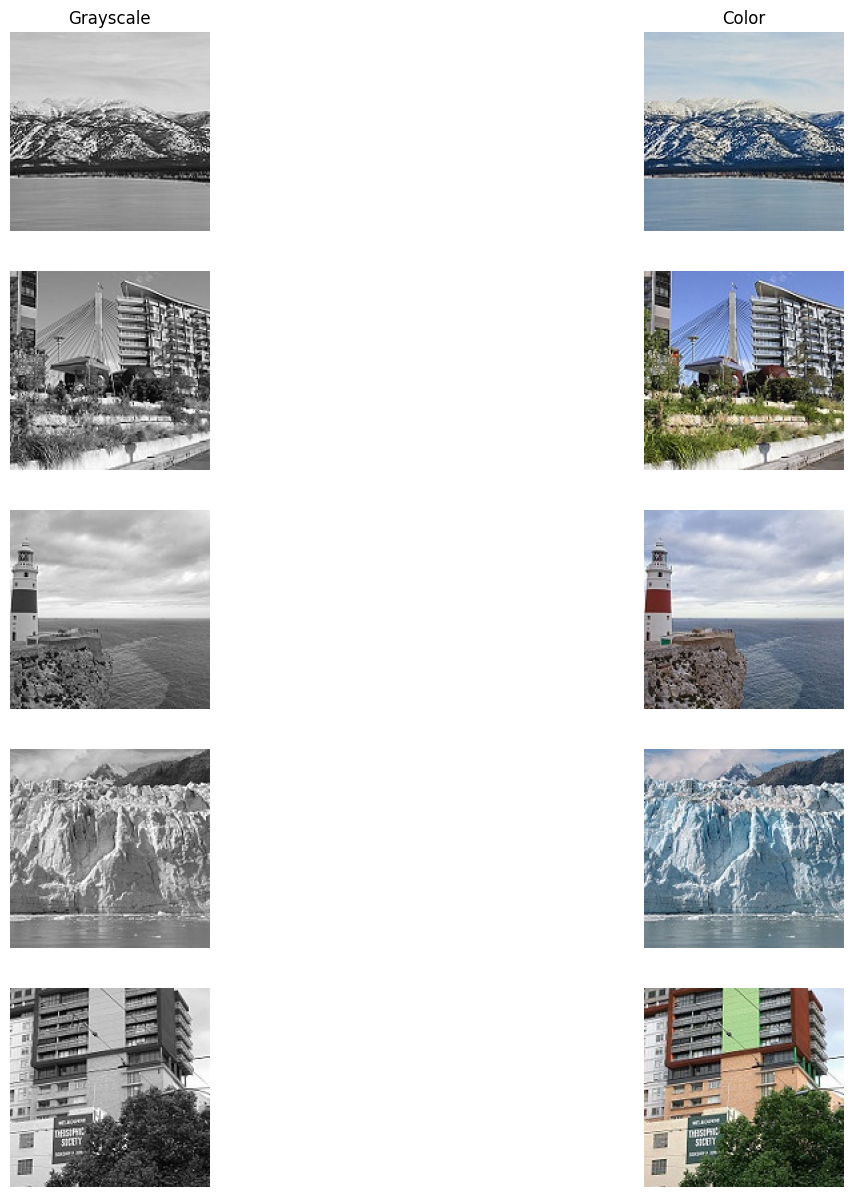

In [13]:
color, gray = next(iter(trainloader))
show_color_gray_images(color, gray)

In [14]:
# import torch
# import torch.nn as nn

# # Custom layer to reshape tensor
# class Reshape(nn.Module):
#     def __init__(self, *shape):
#         super(Reshape, self).__init__()
#         self.shape = shape

#     def forward(self, x):
#         return x.view(self.shape)

# # Custom layer to trim tensor dimensions
# class Trim(nn.Module):
#     def __init__(self):
#         super(Trim, self).__init__()

#     def forward(self, x):
#         return x[:, :, :150, :150]  # Trim the last row and column

# # Define the convolutional autoencoder
# class ConvAutoencoderV2(nn.Module):
#     def __init__(self, latent_dim=128):
#         super(ConvAutoencoderV2, self).__init__()

#         # Encoder
#         self.encoder = nn.Sequential(
#             nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  # [batch, 1, 28, 28] -> [batch, 32, 28, 28]
#             nn.LeakyReLU(0.01),
#             nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # [batch, 32, 28, 28] -> [batch, 64, 14, 14]
#             nn.LeakyReLU(0.01),
#             nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),  # [batch, 64, 14, 14] -> [batch, 64, 7, 7]
#             nn.LeakyReLU(0.01),
#             nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),  # [batch, 64, 7, 7] -> [batch, 64, 7, 7]
#             nn.Flatten(),  # Flatten the tensor for the fully connected layer
#             nn.Linear(64 * 19 * 19, latent_dim)  # [batch, 3136] -> [batch, latent_dim]
#         )

#         # Decoder
#         self.decoder = nn.Sequential(
#             nn.Linear(latent_dim, 64 * 19 * 19),  # [batch, latent_dim] -> [batch, 3136]
#             Reshape(-1, 64, 19, 19),  # Reshape back to [batch, 64, 7, 7]
#             nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # [batch, 64, 19, 19] -> [batch, 64, 38, 38]
#             nn.LeakyReLU(0.01),
#             nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # [batch, 64, 38, 38] -> [batch, 64, 75, 75]
#             nn.LeakyReLU(0.01),
#             nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # [batch, 64, 14, 14] -> [batch, 32, 29, 29]
#             nn.LeakyReLU(0.01),
#             nn.ConvTranspose2d(32, 3, kernel_size=3, stride=1, padding=0),  # [batch, 32, 29, 29] -> [batch, 1, 31, 31]
#             nn.Sigmoid()  # Sigmoid activation to get output in the range [0, 1]
#         )

#     def forward(self, x):
#         x = self.encoder(x)  # Pass input through the encoder
#         x = self.decoder(x)  # Pass encoded representation through the decoder
#         return x

# Custom layer to reshape tensor
class Reshape(nn.Module):
    def __init__(self, *shape):
        super(Reshape, self).__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(self.shape)


# Define the convolutional autoencoder
class ConvAutoencoderV2(nn.Module):
    def __init__(self, latent_dim=128):
        super(ConvAutoencoderV2, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),  # [batch, 1, 150, 150] -> [batch, 32, 75, 75]
            nn.LeakyReLU(0.01),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # [batch, 32, 75, 75] -> [batch, 64, 38, 38]
            nn.LeakyReLU(0.01),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # [batch, 64, 38, 38] -> [batch, 128, 19, 19]
            nn.LeakyReLU(0.01),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),  # [batch, 128, 19, 19] -> [batch, 256, 10, 10]
            nn.LeakyReLU(0.01),
            nn.Flatten(),  # Flatten the tensor for the fully connected layer
            nn.Linear(256 * 10 * 10, latent_dim)  # [batch, 256*10*10] -> [batch, latent_dim]
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256 * 10 * 10),  # [batch, latent_dim] -> [batch, 256*10*10]
            Reshape(-1, 256, 10, 10),  # Reshape back to [batch, 256, 10, 10]
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # [batch, 256, 10, 10] -> [batch, 128, 20, 20]
            nn.LeakyReLU(0.01),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # [batch, 128, 20, 20] -> [batch, 64, 40, 40]
            nn.LeakyReLU(0.01),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # [batch, 64, 40, 40] -> [batch, 32, 80, 80]
            nn.LeakyReLU(0.01),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),  # [batch, 32, 80, 80] -> [batch, 16, 160, 160]
            nn.LeakyReLU(0.01),
            nn.Conv2d(16, 3, kernel_size=3, padding=1),  # [batch, 16, 160, 160] -> [batch, 3, 160, 160]
            nn.Upsample(size=(150, 150), mode='bilinear')  # Resize to [batch, 3, 150, 150]
        )

    def forward(self, x):
        x = self.encoder(x)  # Pass input through the encoder
        x = self.decoder(x)  # Pass encoded representation through the decoder
        return x

In [16]:
# Example usage
latent_dim = 128
autoencoder = ConvAutoencoderV2(latent_dim=latent_dim).to(device)
print(autoencoder)

# Testing with a dummy input
dummy_input = torch.randn(1, 1, 150, 150).to(device)
output = autoencoder(dummy_input)
print(output.shape)  # Should print torch.Size([1, 3, 150, 150])

ConvAutoencoderV2(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): LeakyReLU(negative_slope=0.01)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=25600, out_features=128, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=128, out_features=25600, bias=True)
    (1): Reshape()
    (2): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.01)
    (6): ConvTranspose2d(

In [17]:
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LEARNING_RATE)

In [20]:
def train_autoencoder(num_epochs, model, optimizer, device,
                               train_loader,loss_fun,model_path, valid_loader=None,
                                logging_interval=100,
                               skip_epoch_stats=False):
  log_dict = {'train_loss_per_epoch': []}

  start_time = time.time()

  # Training loop
  for epoch in range(NUM_EPOCHS):
      model.train()
      train_loss = 0.0
      for i, (color, gray) in enumerate(train_loader):
          gray_image = gray.to(device)  # Move images to the same device as the model

          color_image = color.to(device)

          # Forward pass
          reconstructions = model(gray_image)

          # Compute the loss
          loss = loss_fun(color_image,reconstructions)

          # Backward pass and optimization
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          # # LOGGING
          # log_dict['train_loss_per_batch'].append(loss.item())

          if not i % logging_interval:
            print('Epoch: %03d/%03d | Batch %04d/%04d | Loss: %.4f'% (epoch+1, num_epochs, i,
                          len(train_loader), loss))

          train_loss += loss.item()

      print(f'Epoch: {epoch + 1}, Loss: {train_loss:.6f}')
      print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))


  print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))
  if model_path is not None:
    torch.save(model.state_dict(), model_path)

  return log_dict

In [21]:
log_dict = train_autoencoder(num_epochs=NUM_EPOCHS, model=autoencoder,
                                optimizer=optimizer, device=device,model_path=model_path,
                                train_loader=trainloader,loss_fun=loss_function,
                                valid_loader=testloader,
                                skip_epoch_stats=True,
                                logging_interval=250)

Epoch: 001/005 | Batch 0000/0090 | Loss: 0.2383
Epoch: 1, Loss: 8.798109
Time elapsed: 0.23 min
Epoch: 002/005 | Batch 0000/0090 | Loss: 0.0557
Epoch: 2, Loss: 4.076162
Time elapsed: 0.43 min
Epoch: 003/005 | Batch 0000/0090 | Loss: 0.0337
Epoch: 3, Loss: 3.094031
Time elapsed: 0.64 min
Epoch: 004/005 | Batch 0000/0090 | Loss: 0.0328
Epoch: 4, Loss: 2.837677
Time elapsed: 0.86 min
Epoch: 005/005 | Batch 0000/0090 | Loss: 0.0291
Epoch: 5, Loss: 2.701733
Time elapsed: 1.07 min
Total Training Time: 1.07 min


In [22]:
# Visualize some predictions
def show_predictions(color, gray, pred):
    fig, axs = plt.subplots(5, 3, figsize=(15, 15))
    axs[0, 0].set_title('Grayscale')
    axs[0, 1].set_title('Color')
    axs[0, 2].set_title('Predicted')
    for i in range(5):
        axs[i, 0].axis('off')
        axs[i, 0].imshow(gray[i].permute(1,2,0), cmap='gray')
        axs[i, 1].axis('off')
        axs[i, 1].imshow(color[i].permute(1,2,0))
        axs[i, 2].axis('off')
        axs[i, 2].imshow(pred[i].permute(1,2,0))
    plt.show()

In [24]:
# Test on testing data
total_loss = 0.0
with torch.no_grad():
    for idx, (color_img, gray_img) in enumerate(testloader):
        color_img = color_img.to(device)
        gray_img = gray_img.to(device)

        prediction = autoencoder(gray_img)

        loss = loss_function(prediction, color_img)
        total_loss += loss.item()

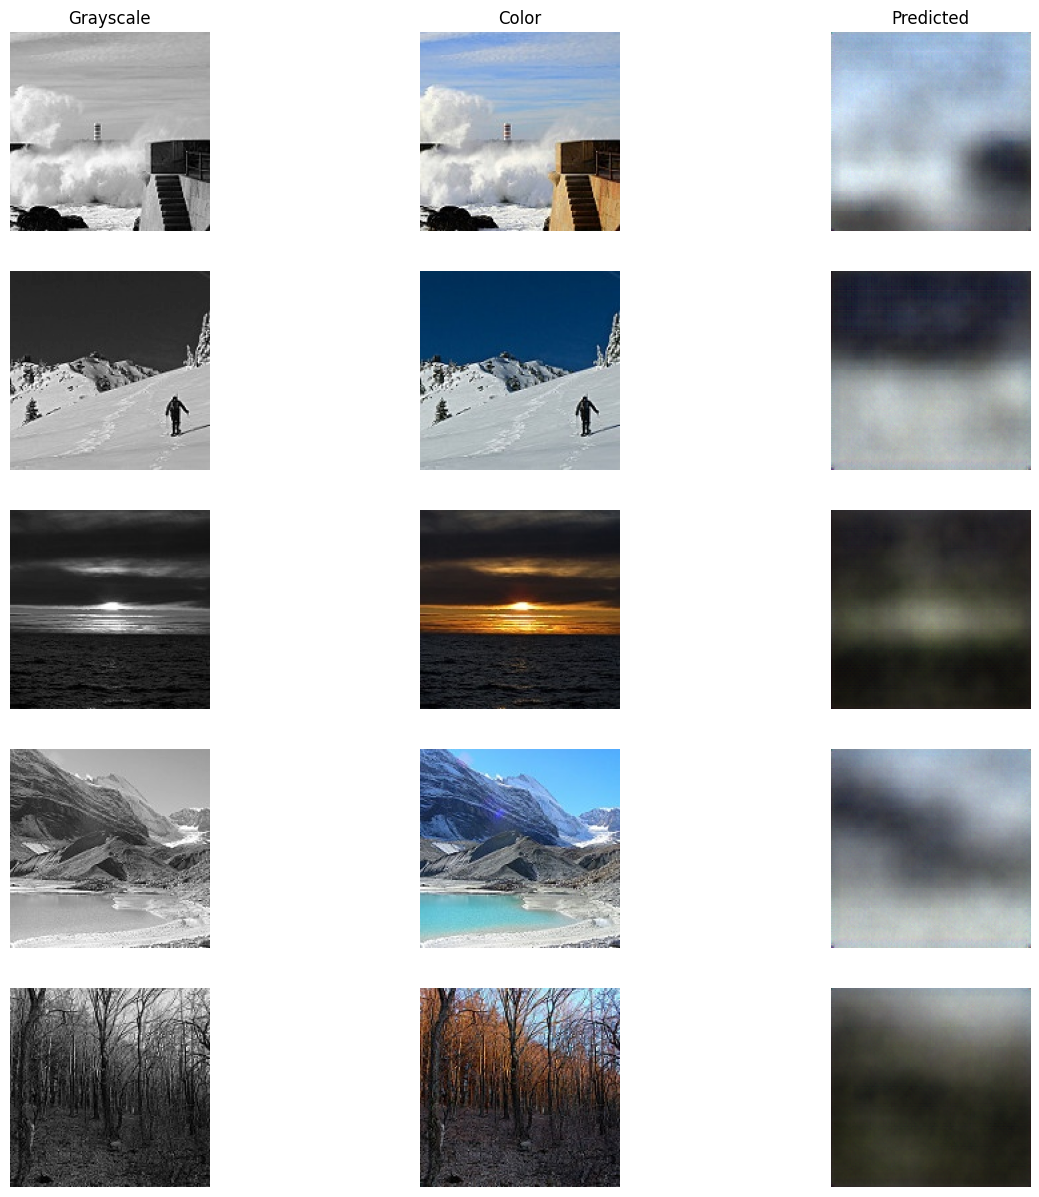

In [25]:
show_predictions(color_img.detach().cpu(), gray_img.detach().cpu(), prediction.detach().cpu())